In [54]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [55]:
drive.mount('/content/drive')
PATH = '/content/drive/My Drive/Colab Notebooks/homerun/'
real_data_path = f'{PATH}arrival_data2.csv'
timetable_path = f'{PATH}gStation3.csv'

def time_to_minutes(time_str):
  # 시간 -> 분
  hours, minutes = map(int, time_str.split(':'))
  return hours * 60 + minutes

def minutes_to_time(minutes):
  # 분 -> 시간
  hours = minutes // 60
  mins = minutes % 60
  return f"{hours:02d}:{mins:02d}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# 1. 데이터 로드
real_data = pd.read_csv(real_data_path)
timetable = pd.read_csv(timetable_path)

print("\ntimetable data:\n", timetable.head())
print("\narrival data:\n", real_data.head())


timetable data:
    FIXED MON_SCHOOL_DEPART MON_STATION_DEPART MON_SCHOOL_ARRIVE  \
0  False              7:55               8:10              8:25   
1   True              8:00               8:15              8:30   
2  False              8:02               8:17              8:32   
3  False              8:03               8:18              8:33   
4   True              8:05               8:20              8:35   

  TUE_SCHOOL_DEPART TUE_STATION_DEPART TUE_SCHOOL_ARRIVE WED_SCHOOL_DEPART  \
0              7:55               8:10              8:25              7:55   
1              8:00               8:15              8:30              8:00   
2              8:02               8:17              8:32              8:02   
3              8:03               8:18              8:33              8:03   
4              8:05               8:20              8:35              8:05   

  WED_STATION_DEPART WED_SCHOOL_ARRIVE THU_SCHOOL_DEPART THU_STATION_DEPART  \
0               8:10           

In [57]:
# 2. 데이터 전처리 시작
days = ['MON', 'TUE', 'WED', 'THU', 'FRI']

# 시간 data -> minutes로 변환
for day in days:
  timetable[f'{day}_SCHOOL_DEPART'] = timetable[f'{day}_SCHOOL_DEPART'].apply(time_to_minutes)
  timetable[f'{day}_STATION_DEPART'] = timetable[f'{day}_STATION_DEPART'].apply(time_to_minutes)
  timetable[f'{day}_SCHOOL_ARRIVE'] = timetable[f'{day}_SCHOOL_ARRIVE'].apply(time_to_minutes)

real_data['ARRIVAL_TIME'] = real_data['ARRIVAL_TIME'].apply(time_to_minutes)

print("\ntimetable data:\n", timetable.head())
print("\narrival data:\n", real_data.head())


timetable data:
    FIXED  MON_SCHOOL_DEPART  MON_STATION_DEPART  MON_SCHOOL_ARRIVE  \
0  False                475                 490                505   
1   True                480                 495                510   
2  False                482                 497                512   
3  False                483                 498                513   
4   True                485                 500                515   

   TUE_SCHOOL_DEPART  TUE_STATION_DEPART  TUE_SCHOOL_ARRIVE  \
0                475                 490                505   
1                480                 495                510   
2                482                 497                512   
3                483                 498                513   
4                485                 500                515   

   WED_SCHOOL_DEPART  WED_STATION_DEPART  WED_SCHOOL_ARRIVE  \
0                475                 490                505   
1                480                 495                

# DAY_SCHOOL_ARRIVE 데이터는 언제 도착한다고 알려줄 때 전혀 쓰지 않아서 필요 없을수도?

In [58]:
# Training data 생성
training_data = []

# 셔틀이 절!대 없는 시간대
NO_SHUTTLE_TIME = [
    ["00:00", "07:40"],
    ["08:30", "08:40"],
    ["09:30", "09:40"],
    ["10:30", "11:45"],
    ["12:30", "12:45"],
    ["13:30", "13:45"],
    ["14:30", "14:45"],
    ["18:45", "19:05"],
    ["19:45", "24:00"]
]
# 분으로 변환
NO_SHUTTLE_TIME = [[time_to_minutes(start), time_to_minutes(end)] for start, end in NO_SHUTTLE_TIME]

for day in days:
    # Real data 전처리
    day_arrivals = real_data[real_data['DAY'] == day]

    # 가짜 데이터 걸러내기
    for start, end in NO_SHUTTLE_TIME:
        day_arrivals = day_arrivals[
            ~((day_arrivals['ARRIVAL_TIME'] >= start) &
              (day_arrivals['ARRIVAL_TIME'] <= end))
        ]

    for _, arrival in day_arrivals.iterrows():
        arrival_time = arrival['ARRIVAL_TIME']
        depart_at = arrival['DEPART_AT']

        # 모든 row를 대상으로 가장 가까운 시간 찾기
        if depart_at == 'STA':
            # station arrival인 경우
            time_diffs = abs(timetable[f'{day}_STATION_DEPART'] - arrival_time)
        else:
            # school arrival인 경우
            time_diffs = abs(timetable[f'{day}_SCHOOL_DEPART'] - arrival_time)

        # 가장 가까운 시간을 가진 row 찾기
        closest_idx = time_diffs.idxmin()
        min_diff = time_diffs.min()

        # 15분 이내의 차이만 인정
        if min_diff <= 15:
            closest_row = timetable.loc[closest_idx]

            # FIXED가 False인 경우만 training data에 추가
            if not closest_row['FIXED']:
                features = {
                    'day': day,
                    'planned_school_depart': closest_row[f'{day}_SCHOOL_DEPART'],
                    'planned_station_depart': closest_row[f'{day}_STATION_DEPART'],
                    'planned_school_arrive': closest_row[f'{day}_SCHOOL_ARRIVE'],
                    'depart_at': depart_at,
                    'arrival_time': arrival_time,
                    # 'is_closest_fixed': closest_row['FIXED']
                }

                if depart_at == 'STA':
                    target = arrival_time - closest_row[f'{day}_STATION_DEPART']
                else:
                    target = arrival_time - closest_row[f'{day}_SCHOOL_DEPART']

                training_data.append({**features, 'target': target})

In [59]:
# 3. 데이터프레임으로 변환
df = pd.DataFrame(training_data)

# 요일을 숫자로 인코딩
day_mapping = {day: i for i, day in enumerate(days)}
df['day'] = df['day'].map(day_mapping)

# depart_at을 숫자로 인코딩
depart_mapping = {'STA': 0, 'SCH': 1}
df['depart_at'] = df['depart_at'].map(depart_mapping)

In [60]:
# 4. 특성과 타겟 분리
features = ['day', 'planned_school_depart', 'planned_station_depart', 'depart_at']
X = df[features]
y = df['target']

In [61]:
# 5. 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# 6. RandomForestRegressor 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [63]:
# 7. 모델 평가
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Training R2 Score: {train_score:.4f}")
print(f"Test R2 Score: {test_score:.4f}")

Training R2 Score: 0.8780
Test R2 Score: -6.4873


In [64]:
# 8. 예측을 위한 새로운 데이터 생성
all_predictions = []

# 9-1. Fixed=True인 행들 먼저 처리
for _, row in timetable[timetable['FIXED']].iterrows():
    prediction_row = {'FIXED': True}
    for day in days:
        school_depart = row[f'{day}_SCHOOL_DEPART']
        station_depart = row[f'{day}_STATION_DEPART']
        school_arrive = row[f'{day}_SCHOOL_ARRIVE']

        prediction_row[f'{day}_SCHOOL_DEPART'] = minutes_to_time(school_depart)
        prediction_row[f'{day}_STATION_DEPART'] = minutes_to_time(station_depart)
        prediction_row[f'{day}_SCHOOL_ARRIVE'] = minutes_to_time(school_arrive)

    # 정렬을 위한 시간 추가
    prediction_row['sort_time'] = row['MON_SCHOOL_DEPART']
    all_predictions.append(prediction_row)

# 9-2. Fixed=False인 행들 예측
for _, row in timetable[~timetable['FIXED']].iterrows():
    prediction_row = {'FIXED': False}
    orig_mon_time = row['MON_SCHOOL_DEPART']  # 정렬용 원본 시간 저장

    for day in days:
        # 학교 출발 예측
        school_features = pd.DataFrame({
            'day': [day_mapping[day]],
            'planned_school_depart': [row[f'{day}_SCHOOL_DEPART']],
            'planned_station_depart': [row[f'{day}_STATION_DEPART']],
            'depart_at': [depart_mapping['SCH']]
        })
        school_pred = model.predict(school_features)[0]

        # 역 출발 예측
        station_features = pd.DataFrame({
            'day': [day_mapping[day]],
            'planned_school_depart': [row[f'{day}_SCHOOL_DEPART']],
            'planned_station_depart': [row[f'{day}_STATION_DEPART']],
            'depart_at': [depart_mapping['STA']]
        })
        station_pred = model.predict(station_features)[0]

        # 예측된 실제 시간 계산
        pred_school_depart = int(row[f'{day}_SCHOOL_DEPART'] + school_pred)
        pred_station_depart = int(row[f'{day}_STATION_DEPART'] + station_pred)
        pred_school_arrive = pred_station_depart + 15

        prediction_row[f'{day}_SCHOOL_DEPART'] = minutes_to_time(pred_school_depart)
        prediction_row[f'{day}_STATION_DEPART'] = minutes_to_time(pred_station_depart)
        prediction_row[f'{day}_SCHOOL_ARRIVE'] = minutes_to_time(pred_school_arrive)

    # 정렬을 위한 시간 추가
    prediction_row['sort_time'] = orig_mon_time
    all_predictions.append(prediction_row)

In [65]:
# 10. 결과를 데이터프레임으로 변환하고 정렬
result_df = pd.DataFrame(all_predictions)
result_df = result_df.sort_values(['FIXED', 'sort_time'], ascending=[False, True])
result_df = result_df.drop('sort_time', axis=1)

In [71]:
# 11. CSV 파일로 저장
output_path = f'{PATH}gStation_predicted_v4.csv'
result_df.to_csv(output_path, index=False)
print(f"\n예측된 시간표가 {output_path}에 저장되었습니다.")


예측된 시간표가 /content/drive/My Drive/Colab Notebooks/homerun/gStation_predicted_v4.csv에 저장되었습니다.


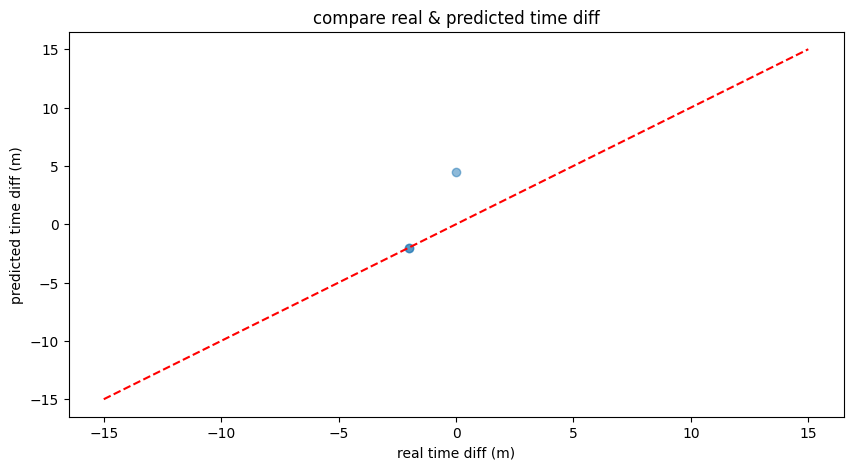

In [69]:
# 12. 모델 성능 시각화
plt.figure(figsize=(10, 5))

# 실제값과 예측값 비교
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-15, 15], [-15, 15], 'r--')
plt.xlabel('real time diff (m)')
plt.ylabel('predicted time diff (m)')
plt.title('compare real & predicted time diff')

# 그래프 저장
plt.show()
plt.close()

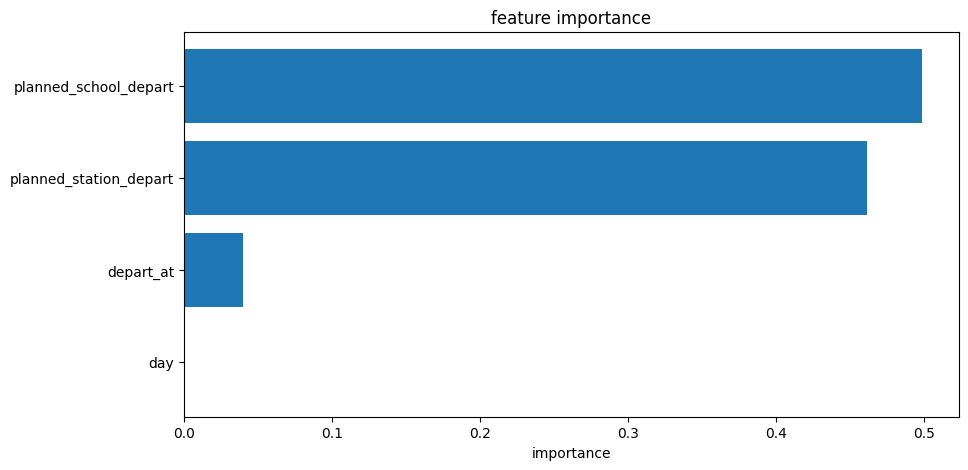


예측 결과 샘플 (처음 5개 행):
   FIXED MON_SCHOOL_DEPART MON_STATION_DEPART MON_SCHOOL_ARRIVE  \
0   True             08:00              08:15             08:30   
1   True             08:05              08:20             08:35   
2   True             09:00              09:15             09:30   
3   True             09:05              09:20             09:35   
4   True             10:00              10:15             10:30   

  TUE_SCHOOL_DEPART TUE_STATION_DEPART TUE_SCHOOL_ARRIVE WED_SCHOOL_DEPART  \
0             08:00              08:15             08:30             08:00   
1             08:05              08:20             08:35             08:05   
2             09:00              09:15             09:30             09:00   
3             09:05              09:20             09:35             09:05   
4             10:00              10:15             10:30             10:00   

  WED_STATION_DEPART WED_SCHOOL_ARRIVE THU_SCHOOL_DEPART THU_STATION_DEPART  \
0              08:15        

In [70]:
# 13. 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('importance')
plt.title('feature importance')
plt.show()
plt.close()

print("\n예측 결과 샘플 (처음 5개 행):")
print(result_df.head())

### R2 Score(결정계수)
- 범위 : -inf ~ 1.0
- 1에 가까울수록 좋은 모델임
- 0 보다 작으면 평균값으로 예측하는 것보다 성능이 나쁘다
- -> 지금 엄청 나쁨

### MAE (Mean Absolute Error)
- 실제값과  예측값의 차이의 절대값 평균
- 단위 : 분
- 값이 작을수록 좋음

### RMSE (Root Mean Squared Error)
- 실제값과 예측값의 차이를 제곱한 후  평균을 구하고 다시 제곱근
- 단위 : 분
- 값이 작을수록 좋음
- MAE보다 큰 오차에 민감

In [ ]:
# 14. 모델 성능 상세 분석
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n모델 성능 지표:")
print(f"Mean Absolute Error: {mae:.2f} 분")
print(f"Root Mean Squared Error: {rmse:.2f} 분")

Training R2 Score: 0.8780
Test R2 Score: -6.4873

예측된 시간표가 /content/drive/My Drive/Colab Notebooks/homerun/predicted_timetable.csv에 저장되었습니다.


<ipython-input-53-a06c4a6fa7ff>:110: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  plt.savefig(f'{PATH}prediction_performance.png')
<ipython-input-53-a06c4a6fa7ff>:110: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  plt.savefig(f'{PATH}prediction_performance.png')
<ipython-input-53-a06c4a6fa7ff>:110: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  plt.savefig(f'{PATH}prediction_performance.png')
<ipython-input-53-a06c4a6fa7ff>:110: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.savefig(f'{PATH}prediction_performance.png')
<ipython-input-53-a06c4a6fa7ff>:110: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  plt.savefig(f'{PATH}prediction_performance.png')
<ipython-input-53-a06c4a6fa7ff>:110: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  plt.savefig(f'{PATH}prediction_performance.png')
<ipyt


예측 결과 샘플 (처음 5개 행):
   FIXED MON_SCHOOL_DEPART MON_STATION_DEPART MON_SCHOOL_ARRIVE  \
0   True             08:00              08:15             08:30   
1   True             08:05              08:20             08:35   
2   True             09:00              09:15             09:30   
3   True             09:05              09:20             09:35   
4   True             10:00              10:15             10:30   

  TUE_SCHOOL_DEPART TUE_STATION_DEPART TUE_SCHOOL_ARRIVE WED_SCHOOL_DEPART  \
0             08:00              08:15             08:30             08:00   
1             08:05              08:20             08:35             08:05   
2             09:00              09:15             09:30             09:00   
3             09:05              09:20             09:35             09:05   
4             10:00              10:15             10:30             10:00   

  WED_STATION_DEPART WED_SCHOOL_ARRIVE THU_SCHOOL_DEPART THU_STATION_DEPART  \
0              08:15        

<ipython-input-53-a06c4a6fa7ff>:124: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  plt.savefig(f'{PATH}feature_importance.png')
<ipython-input-53-a06c4a6fa7ff>:124: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.savefig(f'{PATH}feature_importance.png')
<ipython-input-53-a06c4a6fa7ff>:124: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  plt.savefig(f'{PATH}feature_importance.png')
<ipython-input-53-a06c4a6fa7ff>:124: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  plt.savefig(f'{PATH}feature_importance.png')
<ipython-input-53-a06c4a6fa7ff>:124: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.savefig(f'{PATH}feature_importance.png')
